In [1]:
import os
import shutil

import pickle

from PIL import Image
from IPython.display import display
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

import csv

In [2]:
def move_file_to_folder(source_file, destination_folder):
    # Check if the destination folder exists, if not, create it
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    destination_file_path = os.path.join(destination_folder, source_file)

    # Use shutil.copy to copy the file to the destination folder
    shutil.move(source_file, destination_file_path)

In [3]:
this_directory = os.getcwd()

In [4]:
os.chdir('../final')

# TRAINING DATA
#!python -m tournament.runner_record image_jurgen_agent jurgen_agent -r record.mp4 -s data.pkl 
#!python -m tournament.runner_record geoffrey_agent jurgen_agent -r record.mp4 -s data.pkl 
#!python -m tournament.runner_record yann_agent geoffrey_agent -r record.mp4 -s data.pkl 

# VALIDATION DATA
#!python -m tournament.runner_record image_jurgen_agent yann_agent -r record.mp4 -s data.pkl 
#!python -m tournament.runner_record image_jurgen_agent geoffrey_agent -r record.mp4 -s data.pkl 
#!python -m tournament.runner_record yann_agent jurgen_agent -r record.mp4 -s data.pkl 

# Test Data
#!python -m tournament.runner_record jurgen_agent image_jurgen_agent -r record.mp4 -s data.pkl
#!python -m tournament.runner_record geoffrey_agent yann_agent -r record.mp4 -s data.pkl
#!python -m tournament.runner_record geoffrey_agent image_jurgen_agent -r record.mp4 -s data.pkl
#!python -m tournament.runner_record geoffrey_agent image_jurgen_agent -r record.mp4 -s data.pkl -wh 400 300 
!python -m tournament.runner_record AI AI -r record.mp4 -s data.pkl

destination_directory = this_directory
for file in ['record.mp4','data.pkl']:
    move_file_to_folder(file, destination_directory)

os.chdir(this_directory)

Match results [0, 1]


In [5]:
with open('Images.pkl', 'rb') as f:
    images_data = pickle.load(f)

len(images_data)

4800

In [6]:
def get_puck_box(objects_in_image):
    indices = np.where(objects_in_image == 8)

    if len(indices[0]) > 0:
        min_row = min(indices[0])
        max_row = max(indices[0])
        min_col = min(indices[1])
        max_col = max(indices[1])

        puck_array = np.array([[min_col, min_row, max_col+1, max_row+1]], dtype='uint16')
    
    else:
        puck_array = np.array([], dtype='uint16')

    return puck_array

In [7]:
def _filter(boxes, min_size=20, max_size=np.inf):
    if len(boxes) == 0:
        return boxes, 0
    box_size = abs(boxes[:, 3] - boxes[:, 1]) * abs(boxes[:, 2] - boxes[:, 0])
    return boxes[max_size >= box_size >= min_size], box_size[0]

In [8]:
def append_row_to_csv(file_path, file_name, label):
    # Open the CSV file in append mode
    with open(file_path, 'a', newline='') as csvfile:
        # Create a csv.writer object
        writer = csv.writer(csvfile)
        
        # Write header if the file is empty
        if csvfile.tell() == 0:
            writer.writerow(["file", "label"])
        
        # Write the row data
        writer.writerow([file_name, label])

In [9]:
keep_images_without_puck = True
min_puck_size = 6
max_puck_size = np.inf #120
max_file_count = np.inf #4201 #
data_dir = 'dense_data/test'

os.chdir(this_directory)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
os.chdir(data_dir)

files = 0
puck_sizes = {}

for number, dataset_tuple in images_data.items():
    if files > max_file_count:
        break
    if len(dataset_tuple) != 1:
        print("Error! The length of the dataset is", len(dataset_tuple))
    dataset = dataset_tuple[0]
    write = True
    puck = "No_Puck"
    for name, value in dataset.items():
        if name.__contains__('labels'):
            objects_in_image = value
            puck_array = get_puck_box(objects_in_image)
            puck_array, puck_size = _filter(puck_array, min_size=min_puck_size, max_size=max_puck_size)
            if (len(puck_array) == 0):
                write = keep_images_without_puck
                if (puck_size > max_puck_size):
                    write = False
            else:
                puck = 'Puck'
        elif name.__contains__('img'):
            img_array = value
            img = Image.fromarray(np.uint8(img_array))
    if write:
        np.savez_compressed(name.replace('labels','boxes')+'.npz', puck=puck_array)
        #plt.imsave(name+'.png', objects_in_image, cmap='gray')
        img.save(name+'.jpg')
        append_row_to_csv('labels.csv', name+'.jpg', puck)
        puck_sizes[puck_size] = {'img':img, 'size':puck_size, 'png':objects_in_image, 'array':puck_array}
        files += 1

os.chdir(this_directory)

In [10]:
# Initialize a counter for the number of files
file_count = 0

# Iterate over the files in the folder
for filename in os.listdir(data_dir):
    # Check if the filename is a file (not a directory)
    if os.path.isfile(os.path.join(data_dir, filename)):
        file_count += 1

print(f'The folder contains {file_count} files from {int((file_count-1)/2)} images.')


The folder contains 9601 files from 4800 images.


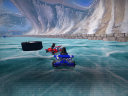

In [11]:
img

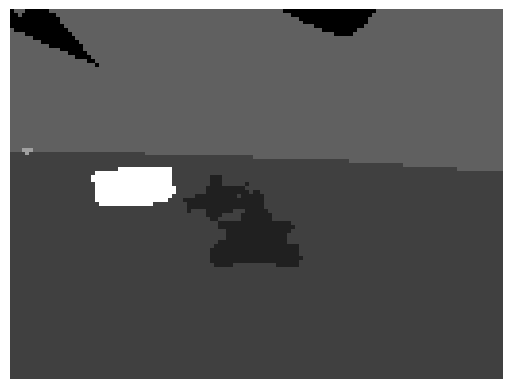

In [12]:
plt.imshow(objects_in_image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

In [13]:
puck_array

array([[21, 41, 43, 51]], dtype=uint16)